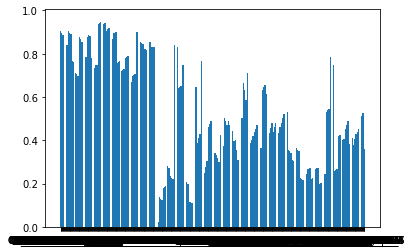

In [2]:
'''plt.close()
xmetric = 'spec_AE'
agg = 1
ap = 0
ymetric = 'test_acc'
x = aggregates[xmetric][agg][ap]
y = aggregates[ymetric]
plt.plot(x,y,'ro')
m, b = np.polyfit(x,y, 1)
plt.plot(np.arange(min(x),max(x),0.005),m*np.arange(min(x),max(x),0.005)+b)
plt.title(ymetric+" versus $\widehat{Q}^{L2}_{S}$")
plt.show()'''
correlations = correlations[]
plt.bar(correlationsp.keys(),correlationsp.values())
plt.show()

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import numpy.linalg as LA
from scipy import stats
import math
import numpy.ma as ma
import matplotlib.pyplot as plt
import numpy.ma as ma
from pathlib import Path
import sys

def agg(x, L, a=[]):
    if(L == 1):
        a = np.logical_not(ma.getmaskarray(x))
        return np.average(np.abs(x),weights=a,axis=1)
    if(L == 2):
        a = np.logical_not(ma.getmaskarray(x))
        return LA.norm(x,axis=1)/np.sqrt(np.sum(a,axis=1))
    if(L == 3):
        a = np.logical_not(ma.getmaskarray(x))
        return np.prod(np.power(x,a/np.repeat(np.expand_dims(np.sum(a,axis=1),axis=1),a.shape[1],axis=1)),axis=1)
    if(L == 4):
        a = a*np.logical_not(ma.getmaskarray(x))
        return np.average(np.abs(x),weights=a,axis=1)
    if(L == 5):
        a = a*np.logical_not(ma.getmaskarray(x))
        return np.prod(np.power(x,a/np.repeat(np.expand_dims(np.sum(a,axis=1),axis=1),a.shape[1],axis=1)),axis=1)

def all_aggs(in_chan, out_chan, in_weight, out_weight):
    return np.asarray([agg(np.ma.concatenate((in_chan,out_chan),axis=1),L=i,a=np.ma.concatenate((in_weight,out_weight),axis=1)) for i in range(1,6)])

def sqrtlog(chans, weights):
    a = np.logical_not(ma.getmaskarray(weights))
    all = []
    for i in range(len(chans)):
        all.append([])
        chand = chans[i]*np.sum(a,axis=1)
        all[i].append(chans[i])
        all[i].append(chand)
        all[i].append(np.sqrt(chans[i]))
        all[i].append(np.sqrt(chand))
        all[i].append(np.log(chans[i]))
        all[i].append(np.log(chand))
        all[i].append(np.log(np.sqrt(chans[i])))
        all[i].append(np.log(np.sqrt(chand)))
    return all

def correlate(filename):
    file=Path(str(sys.path[0][0:-7])+"/outputs/"+filename+".csv")
    df = pd.read_csv(file,skip_blank_lines=False)
    data = dict()

    if(pd.isna(df.iloc[-1][1])):
        df = df.drop(labels=df.shape[0]-1, axis=0)

    zero_models = []

    idx = list(np.where(pd.isna(df["model_id"]))[0])
    idxcopy = idx
    idx = idx - np.arange(0,len(idx),1)
    lenidx = np.append(idx,len(df["model_id"])-len(idx))
    lenidx = np.insert(lenidx,0,0)
    maxLength = np.max(np.abs(np.diff(lenidx)))
    for key in list(df.keys()):
        idxx = list(np.where(pd.isna(df[key]))[0])
        idxx = list(set(idxcopy) ^ set(idxx))
        data[key] = df[key]
        datacopy = data[key]
        data[key].loc[idxx] = 0
        data[key] = data[key].dropna(axis=0)
        data[key] = np.array_split(data[key],idx)
        
        for i in range(len(data[key])):
            #equalize all model sizes
            prevlen = len(data[key][i])
            data[key][i] = np.append(data[key][i],(np.zeros((maxLength-len(data[key][i])))))
            #delete zero models
            num_non_zero = np.sum(data[key][i]!=0)
            threshold = 1
            if(num_non_zero<threshold):
                #print(key,str(i),num_non_zero,prevlen)
                zero_models.append(i)
        data[key] = np.asarray(data[key])
        
    zero_models = list(set(zero_models))
    #print("zero models deleted: "+str(len(zero_models)))
    for key in list(data.keys()):
        data[key] = np.delete(data[key],zero_models,axis=0)
        data[key] = ma.masked_array(data[key], mask=(data[key]==0.))
    
    data['in_QS_BE'] = np.arctan2(data['in_S_BE'],(1-1/data['in_C_BE']))
    data['out_QS_BE'] = np.arctan2(data['out_S_BE'],(1-1/data['out_C_BE']))
    data['in_QS_AE'] = np.arctan2(data['in_S_AE'],(1-1/data['in_C_AE']))
    data['out_QS_AE'] = np.arctan2(data['out_S_AE'],(1-1/data['out_C_AE']))

    aggregates = dict()

    aggregates['QS_BE'] = all_aggs(data['in_QS_BE'],data['out_QS_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['QS_AE'] = all_aggs(data['in_QS_AE'],data['out_QS_AE'],data['in_weight_AE'],data['out_weight_AE'])
    aggregates['QE_BE'] = all_aggs(data['in_ER_BE'],data['out_ER_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['QE_AE'] = all_aggs(data['in_ER_AE'],data['out_ER_AE'],data['in_weight_AE'],data['out_weight_AE'])

    aggregates['QS_BE'] = sqrtlog(aggregates['QS_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['QS_AE'] = sqrtlog(aggregates['QS_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))
    aggregates['QE_BE'] = sqrtlog(aggregates['QE_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['QE_AE'] = sqrtlog(aggregates['QE_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))
  
    aggregates['spec_BE'] = all_aggs(data['in_spec_BE'],data['out_spec_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['spec_AE'] = all_aggs(data['in_spec_AE'],data['out_spec_AE'],data['in_weight_AE'],data['out_weight_AE'])
    aggregates['fro_BE'] = all_aggs(data['in_fro_BE'],data['out_fro_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['fro_AE'] = all_aggs(data['in_fro_AE'],data['out_fro_AE'],data['in_weight_AE'],data['out_weight_AE'])

    aggregates['spec_BE'] = sqrtlog(aggregates['spec_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['spec_AE'] = sqrtlog(aggregates['spec_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))
    aggregates['fro_BE'] = sqrtlog(aggregates['fro_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['fro_AE'] = sqrtlog(aggregates['fro_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))

    aggregates['path'] = np.mean(data['path'],axis=1)

    aggregates['test_acc'] = np.mean(data['test_acc'],axis=1)
    aggregates['train_acc'] = np.mean(data['train_acc'],axis=1)
    aggregates['test_loss'] = np.mean(data['test_loss'],axis=1)
    aggregates['train_loss'] = np.mean(data['train_loss'],axis=1)
    aggregates['gap'] = np.mean(data['gap'],axis=1)



    #correlations
    X = ['test_acc','gap']
    Y = ['QS_BE','QS_AE','QE_BE','QE_AE','spec_BE','spec_AE','fro_BE','fro_AE']
    correlationsp = dict()
    correlationss = dict()
    for x in X:
        for y in Y:
            for i in range(5):
                for t in range(8):
                    correlationsp[y+'_'+x+'_L'+str(i+1)+"_"+str(t)] = abs(stats.pearsonr(aggregates[x], aggregates[y][i][t])[0])
                    correlationss[y+'_'+x+'_L'+str(i+1)+"_"+str(t)] = abs(stats.spearmanr(aggregates[x], aggregates[y][i][t])[0])
        correlationsp["path_"+x] = abs(stats.pearsonr(aggregates[x], aggregates['path'])[0])
        correlationss["path_"+x] = abs(stats.spearmanr(aggregates[x], aggregates['path'])[0])
    correlations = {'pearson':correlationsp,'spearman':correlationss}
    #print(correlations)
    
    return correlations

if __name__ == "__main__":
    filename = "results-06-18-2021_17-27-02-NATSS-cifar10-90"
    file=Path(str(sys.path[0][0:-7])+"/outputs/"+filename+".csv")
    df = pd.read_csv(file,skip_blank_lines=False)
    data = dict()

    if(pd.isna(df.iloc[-1][1])):
        df = df.drop(labels=df.shape[0]-1, axis=0)

    zero_models = []

    idx = list(np.where(pd.isna(df["model_id"]))[0])
    idxcopy = idx
    idx = idx - np.arange(0,len(idx),1)
    lenidx = np.append(idx,len(df["model_id"])-len(idx))
    lenidx = np.insert(lenidx,0,0)
    maxLength = np.max(np.abs(np.diff(lenidx)))
    for key in list(df.keys()):
        idxx = list(np.where(pd.isna(df[key]))[0])
        idxx = list(set(idxcopy) ^ set(idxx))
        data[key] = df[key]
        datacopy = data[key]
        data[key].loc[idxx] = 0
        data[key] = data[key].dropna(axis=0)
        data[key] = np.array_split(data[key],idx)
    
        for i in range(len(data[key])):
            #equalize all model sizes
            prevlen = len(data[key][i])
            data[key][i] = np.append(data[key][i],(np.zeros((maxLength-len(data[key][i])))))
            #delete zero models
            num_non_zero = np.sum(data[key][i]!=0)
            threshold = 1
            if(num_non_zero<threshold):
                #print(key,str(i),num_non_zero,prevlen)
                zero_models.append(i)
        data[key] = np.asarray(data[key])
    
    zero_models = list(set(zero_models))
    print("zero models deleted: "+str(len(zero_models)))
    for key in list(data.keys()):
        data[key] = np.delete(data[key],zero_models,axis=0)
        data[key] = ma.masked_array(data[key], mask=(data[key]==0.))

    data['in_QS_BE'] = np.arctan2(data['in_S_BE'],(1-1/data['in_C_BE']))
    data['out_QS_BE'] = np.arctan2(data['out_S_BE'],(1-1/data['out_C_BE']))
    data['in_QS_AE'] = np.arctan2(data['in_S_AE'],(1-1/data['in_C_AE']))
    data['out_QS_AE'] = np.arctan2(data['out_S_AE'],(1-1/data['out_C_AE']))

    aggregates = dict()

    aggregates['QS_BE'] = all_aggs(data['in_QS_BE'],data['out_QS_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['QS_AE'] = all_aggs(data['in_QS_AE'],data['out_QS_AE'],data['in_weight_AE'],data['out_weight_AE'])
    aggregates['QE_BE'] = all_aggs(data['in_ER_BE'],data['out_ER_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['QE_AE'] = all_aggs(data['in_ER_AE'],data['out_ER_AE'],data['in_weight_AE'],data['out_weight_AE'])

    aggregates['QS_BE'] = sqrtlog(aggregates['QS_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['QS_AE'] = sqrtlog(aggregates['QS_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))
    aggregates['QE_BE'] = sqrtlog(aggregates['QE_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['QE_AE'] = sqrtlog(aggregates['QE_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))

    aggregates['spec_BE'] = all_aggs(data['in_spec_BE'],data['out_spec_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['spec_AE'] = all_aggs(data['in_spec_AE'],data['out_spec_AE'],data['in_weight_AE'],data['out_weight_AE'])
    aggregates['fro_BE'] = all_aggs(data['in_fro_BE'],data['out_fro_BE'],data['in_weight_BE'],data['out_weight_BE'])
    aggregates['fro_AE'] = all_aggs(data['in_fro_AE'],data['out_fro_AE'],data['in_weight_AE'],data['out_weight_AE'])

    aggregates['spec_BE'] = sqrtlog(aggregates['spec_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['spec_AE'] = sqrtlog(aggregates['spec_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))
    aggregates['fro_BE'] = sqrtlog(aggregates['fro_BE'],np.ma.concatenate((data['in_weight_BE'],data['out_weight_BE']),axis=1))
    aggregates['fro_AE'] = sqrtlog(aggregates['fro_AE'],np.ma.concatenate((data['in_weight_AE'],data['out_weight_AE']),axis=1))

    aggregates['path'] = np.mean(data['path'],axis=1)

    aggregates['test_acc'] = np.mean(data['test_acc'],axis=1)
    aggregates['train_acc'] = np.mean(data['train_acc'],axis=1)
    aggregates['test_loss'] = np.mean(data['test_loss'],axis=1)
    aggregates['train_loss'] = np.mean(data['train_loss'],axis=1)
    aggregates['gap'] = np.mean(data['gap'],axis=1)



    #correlations
    X = ['test_acc','gap']
    Y = ['QS_BE','QS_AE','QE_BE','QE_AE','spec_BE','spec_AE','fro_BE','fro_AE']
    correlationsp = dict()
    correlationss = dict()
    for x in X:
        for y in Y:
            for i in range(5):
                for t in range(8):
                    correlationsp[y+'_'+x+'_L'+str(i+1)+"_"+str(t)] = abs(stats.pearsonr(aggregates[x], aggregates[y][i][t])[0])
                    correlationss[y+'_'+x+'_L'+str(i+1)+"_"+str(t)] = abs(stats.spearmanr(aggregates[x], aggregates[y][i][t])[0])
        correlationsp["path_"+x] = abs(stats.pearsonr(aggregates[x], aggregates['path'])[0])
        correlationss["path_"+x] = abs(stats.spearmanr(aggregates[x], aggregates['path'])[0])
    correlations = {'pearson':correlationsp,'spearman':correlationss}
    print(len(aggregates['test_acc']))

zero models deleted: 1
26517
